## CARAVANA IMAGE MASKING CHALLEGE

Caravana is successful online used car startup in US. In-order to enhance their user experience, Caravana takes 16 high quality photos from different angles. Once captured they are processed through their custom rotating photo studio Algorithm which allows users to rotate the image in 3d and view the car in different angles. Bright reflections and cars with similar colors as background have made masking task very difficult (Fig 1). Caravana decided to look at deep learning solutions that will mask away the entire background and only pops out the car from the image. This is a classic image segmentation (semantic) task.

To note a few things 
- This competation uses dice coeffient as metric (We will discuss about the metrics in the later section)
-  Each car has exactly 16 images, each one taken at different angles. Each car has a unique id and images are named according to id_01.jpg, id_02.jpg ... id_16.jpg. 
- some basic metadata about the car make, model, year, and trim is also provided (Ignored in this section)

This competiation contains several files
- train images - split into train and validation in the later stages
- test images (Not used in this version)
- metadata.csv: contains the meta data of each car. We will not be using this information in this task for reasons metioned below 
- train_masks.csv: contains image_name and rle mask of the image. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['metadata.csv', 'train_masks', 'train_masks.csv', 'test', 'train', 'sample_submission.csv']


## why not using metadata.csv ?

Before talking about why I am not using the meta data. Let me talk about how we can use this information
- we can add meta information as a linear layer to the neural network so that we can condition each mask based on their type, model, year.
- we can train different models for different models, type, year etc
- Once the segmenation model is trained, we can look at on what images the model is not performing well and compare it with metadata to better understand where the model is not working and where it working well.

We have to use the first two methods only when our basic segmentation model is not working well and also after doing a thorough analysis on the failure of our basic model. Without this analysis making our model complicated is not advisable. For starters in Machine learning always start with the basic model and basic data before exploring more frontiers. We will look at this in depth in the coming sessions. 

## Analyzing the Data

In [2]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline 

#import cv2
from PIL import Image
from tqdm import tqdm
import glob

from keras.preprocessing import image
from os.path import join

Using TensorFlow backend.


## Lets verify the following statements
- How many images are available for training ?
- weather each id has 16 images or not ?

In [3]:
## Reading train_masks.csv file
train = pd.read_csv("../input/train_masks.csv")
train.shape

(5088, 2)

In [4]:
## Extracting the Id
train["id"] = train["img"].apply(lambda x: x.rsplit("_")[0])
train.head()

,img,rle_mask,id
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...,00087a6bd4dc
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...,00087a6bd4dc
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...,00087a6bd4dc
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...,00087a6bd4dc
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...,00087a6bd4dc


In [5]:
## Count of each Id
train["id"].value_counts().values

array([16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16,
       16, 16, 16, 16, 16

In [6]:
print("Total number of cars: {}".format(train["id"].value_counts().shape))

Total number of cars: (318,)


## Observations
- Total number of images: 5088
- Total number of cars (each car contains 16 images): 318

## VISUALIZING INPUT IMAGES

In [7]:
## list train images
train_images = glob.glob("../input/train/*.jpg")
len(train_images)

5088

In [8]:
def plot_images(img_list, key="input_images"):
    """ Plots 4 images in a column
    img_list: List of image location to plot
    """
    images = [ image.img_to_array(Image.open(i).convert("RGB"))/255 for i in img_list]
    fig,ax = plt.subplots(nrows=1,ncols=4,sharex="col",sharey="row",figsize=(20,3))
    fig.suptitle(key,fontsize=16)
    for i,img in enumerate(images):
        ax[i].imshow(img)

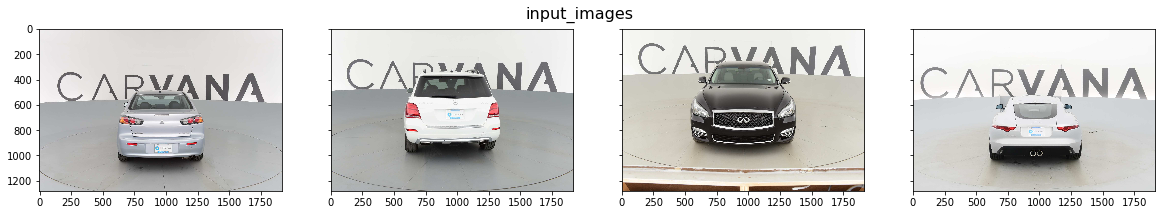

In [9]:
## Randomly picking 4 images
loc_4 = [train_images[np.random.randint(len(train_images))] for _ in range(4)]
plot_images(loc_4)

## Observations
- Different cars are kept on a rotating disk and photos were taken from different angle
- There is caravana written on background.
- Cars are of different colors and models as mentioned in the metadata.

## Visualizing the gif images 
- to understand what the expected output looks like 

In [10]:
## listing gif images 
gif_images = glob.glob("../input/train_masks/*.gif")
len(gif_images)

5088

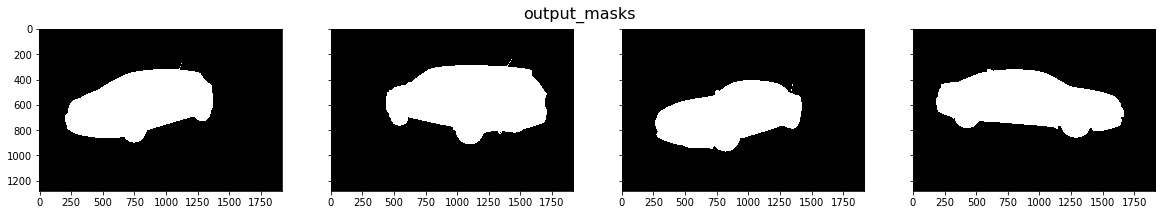

In [11]:
## Randomly picking 4 images
loc_4 = [gif_images[np.random.randint(len(train_images))] for _ in range(4)]
plot_images(loc_4, key="output_masks")

## visualize input to output using these images 

In [12]:
## Given id print Image and Image mask 
def get_image_and_mask(img_id, data_dir = '../input'):
    img = image.load_img(join(data_dir, 'train', '%s.jpg' % img_id))#,
                         #target_size=(input_size, input_size))
    img = image.img_to_array(img)
    mask = image.load_img(join(data_dir, 'train_masks', '%s_mask.gif' % img_id), color_mode="grayscale")#,
                          #grayscale=True, target_size=(input_size, input_size))
    mask = image.img_to_array(mask)
    img, mask = img / 255., mask / 255.
    return img, mask

def plot_img_and_mask(img, mask):
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    #for ax in axs:
    #    ax.set_xlim(0, 512)
    #    ax.axis('off')
    fig.tight_layout()
    plt.show()

0ed6904e1004_07


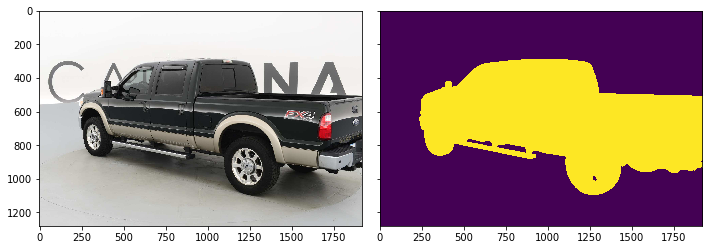

e114fcbb9723_04


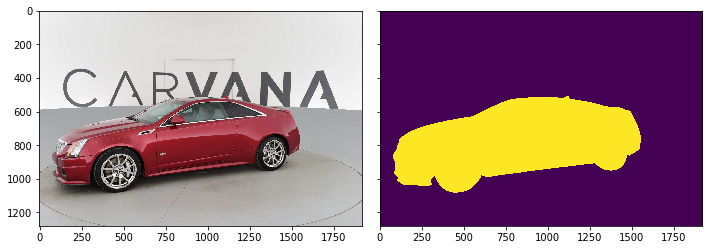

8b4b87ad7be6_01


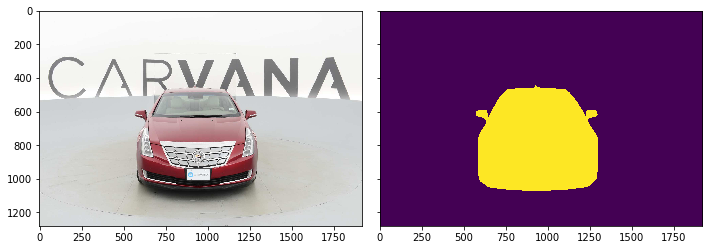

5bc30efeb7bf_15


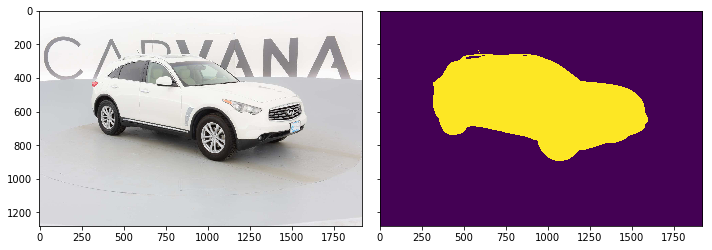

6ae670e86620_10


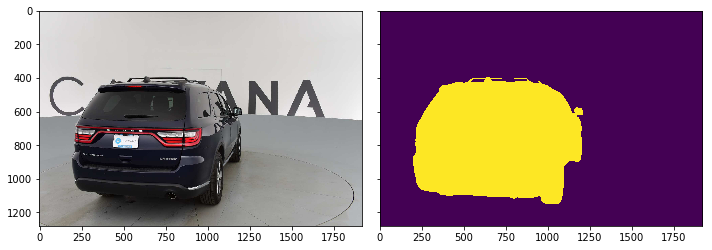

In [13]:
img_id = [train["img"].values[np.random.randint(train.shape[0])].rsplit(".")[0] for i in range(5)]
#print(img_id)
for i in img_id:
    print(i)
    img, mask = get_image_and_mask(i)
    plot_img_and_mask(img, mask)
#plot_img_and_mask()

Looking at the images above u have the feeling that these are of very low quality but that is not the case
- How large are these images ?
- How are the images sizes, aspect ratios changing across images?

In [14]:
img_size = [image.load_img(i).size for i in tqdm(train_images)]
h  = [i[1] for i in img_size]
w = [i[0] for i in img_size]

100%|██████████| 5088/5088 [00:15<00:00, 329.96it/s]


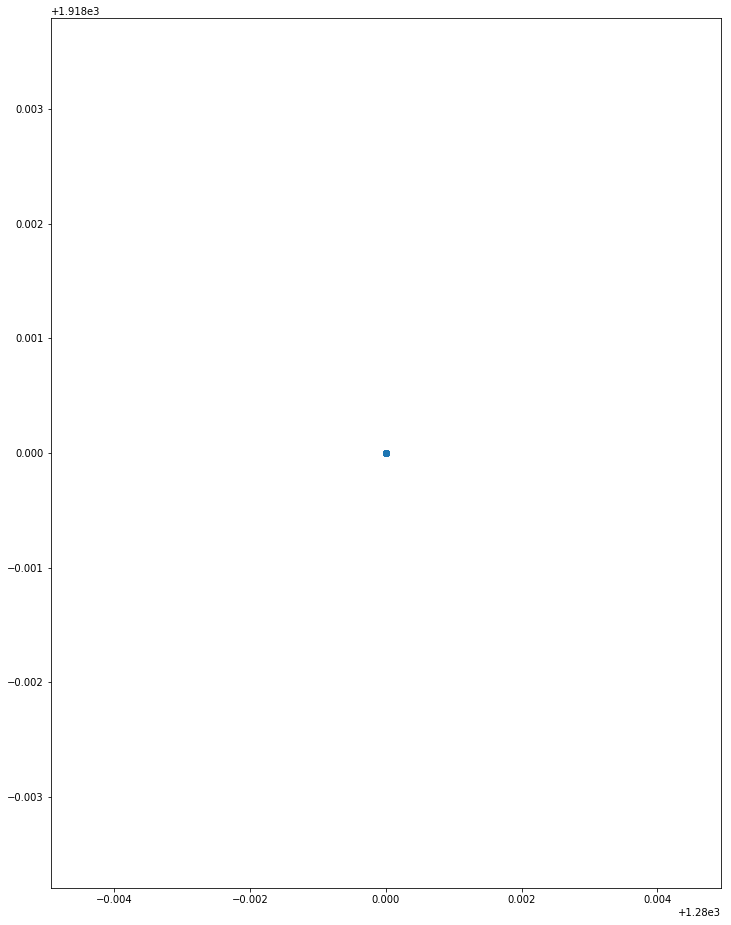

In [15]:
plt.figure(figsize=(12, 16))
plt.scatter(h, w)
plt.show()

This is it. In the next section lets look at various transformations we can apply for segmentation of data

# Data Transformation vs Agumentation

Data transformations are a way of agumenting the dataset and generalizing the network to various disturbances and thus improving the network performace. 

Since our caravana dataset only contains 5088 images for training. Data agumentation using transformations plays an important role. Students can verify this later using **transformation=False** and check the metric values and loss values.

Some of the **image transformations** includes.  
1) Flip  
2) Rotate  
3) Shift  
4) Zoom  
5) Shear  
6) Color transformations  
7) Random channel shift  
8) Grayscale convertor  

we cannot directly use our **keras Image processing** ([Link](https://keras.io/preprocessing/image/)) for segmentation task because the module is written for only image classification task. The outputs are not processed in the same way as inputs. We will be doing the following things below.  
1) Perform various transformations, plot and check if everything is working correctly or not.  
3) write a generator module similar to keras Image processing module to generate images in batches.  

Unlike in previous sections, lets resize all the images to (512, 512) before transformations. this will help us in two ways  
1) transformations will be fast thus increasing the speed of the training.  
2) Larger image sizes lead to computational problems. 

**Note:** Though we will be using (512, 512) images in this section for transformations and later for training. this is a hyper-parameter to tune. Usually the small size images will lead to faster training but less accuracy. Large size images will lead to better accuracies but will take longer times to train and lead to computational problems. Also increasing the image sizes will not continously increase the accuracies, it saturates after reaching certain size. It is a good idea to take small sample data and train the network at various image sizes (320 and multiples of 32 from der) and check the graph and find the optimal size to train.

## Writing a func to see the 
- input image and output mask
- transformed image and transformed mask 

This is important as it will allow us to verify all our transfomations.

In [16]:
def plot_img_and_mask_transformed(img, mask, img_tr, mask_tr):
    """ plot the input image, output mask, transformed images and transformed mask
    
    img: input image, array
    mask: output mask, array
    img_tr: transformed input image, array
    mask: transformed output mask, array
    """
    
    ## Using 4 columns for 4 images
    fig, axs = plt.subplots(ncols=4, figsize=(16, 4), sharex=True, sharey=True)
    axs[0].imshow(img)
    axs[1].imshow(mask[:, :, 0])
    axs[2].imshow(img_tr)
    axs[3].imshow(mask_tr[:, :, 0])
    #for ax in axs:
    #    ax.set_xlim(0, input_size)
    #    ax.axis('off')
    fig.tight_layout()
    plt.show()

### Transformations. Lets take an image id and perform all the transformations on it.
- I am creating a new column called **img_id** which will strip the .jpg from the id. We will use this id to call the image. We can do this efficiently using lambda and apply functions in pandas.

In [17]:
train["img_id"] = train["img"].apply(lambda x: x.rsplit(".")[0])
train.head()

,img,rle_mask,id,img_id
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...,00087a6bd4dc,00087a6bd4dc_01
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...,00087a6bd4dc,00087a6bd4dc_02
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...,00087a6bd4dc,00087a6bd4dc_03
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...,00087a6bd4dc,00087a6bd4dc_04
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...,00087a6bd4dc,00087a6bd4dc_05


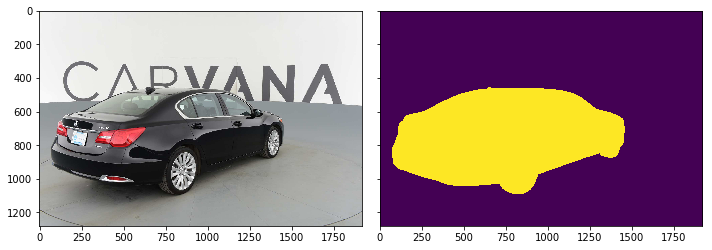

In [18]:
## Ploting an image and mask 
img, mask = get_image_and_mask(train["img_id"].values[10])
plot_img_and_mask(img, mask)

 # Horizontal Flip Image
- The below function tells you how to flip the image 

In [19]:
def random_flip(img, mask, u=0.5):
    """
    img: imaga nd array
    mask: mask
    u: probabality of applying flip
    """
    if np.random.random() < u:
        img =np.flip(img, 1)
        mask = np.flip(mask, 1)
    return img, mask

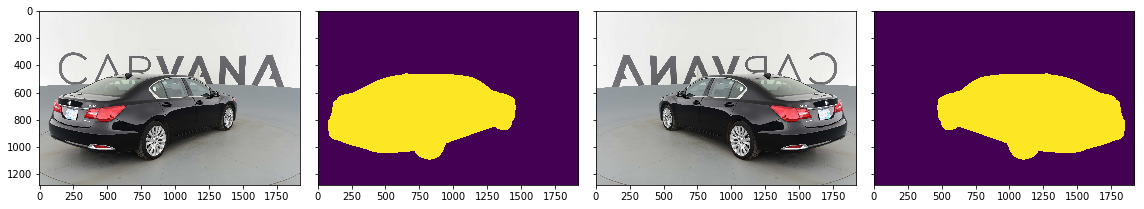

In [20]:
img_flip, mask_flip = random_flip(img, mask, u=1)
plot_img_and_mask_transformed(img, mask, img_flip, mask_flip)

# Rotate
- rotate the image by an angle. Here we are using the default rotate limit between -20 to 20 and the probability of rotating the image as 0.5.
- Using rotate function from skimage transforms.

In [21]:
from skimage import transform

def random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5):
    if np.random.random() < u:
        angle = np.random.uniform(rotate_limit[0], rotate_limit[1])
        img = transform.rotate(img, angle)
        mask = transform.rotate(mask, angle)
    return img, mask

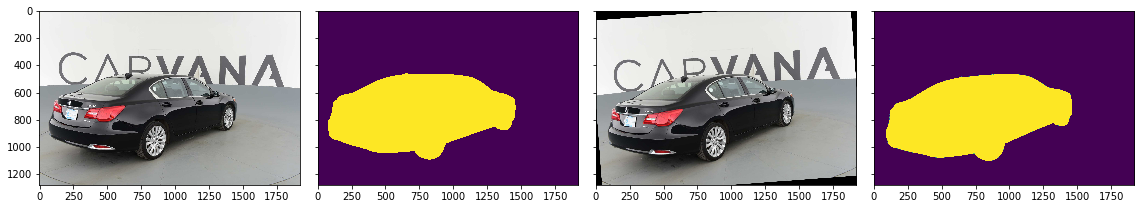

In [22]:
rotate_limit=(-60, 60)
img_rot, mask_rot = random_rotate(img, mask, rotate_limit,  u=1)
plot_img_and_mask_transformed(img, mask, img_rot, mask_rot)

# shift
- Shift the image by a specific location.  There is a w_limit and h_limit for shifting the image horizontal and vertically respectively. 
- Too much shifting might break the car into two parts and we need to be careful withit

In [23]:
from skimage.transform import AffineTransform, warp

def random_shift(img, mask, w_limit=(-10, 10), h_limit=(-10, 10), u=0.5):
    if np.random.random() < u:
        wshift = np.random.uniform(w_limit[0], w_limit[1])
        hshift = np.random.uniform(h_limit[0], h_limit[1])
        transform = AffineTransform(translation=(wshift, hshift))
        img = warp(img, transform, mode='wrap', preserve_range=True)
        mask = warp(mask, transform, mode='wrap', preserve_range=True)
    return img, mask

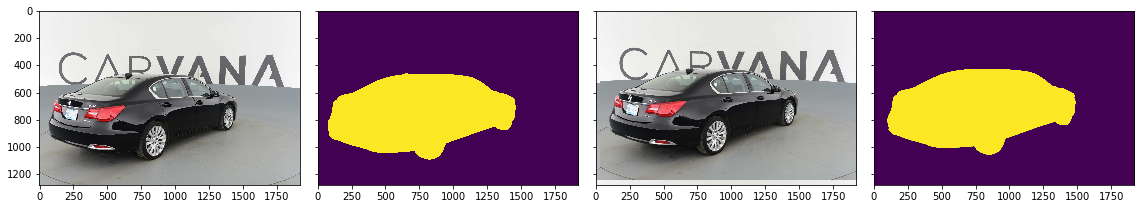

In [24]:
img_shift, mask_shift = random_shift(img, mask, w_limit=(-40, 20), h_limit=(-40, 40),  u=1)
plot_img_and_mask_transformed(img, mask, img_shift, mask_shift)

# ZOOM
- Randomly zoom the image and mask.

In [25]:
def random_zoom(img, mask, zoom_range=(0.8, 1), u=0.5):
    if np.random.random() < u:
        zx, zy = np.random.uniform(zoom_range[0], zoom_range[1], 2)
        img = image.apply_affine_transform(img, zx=zx, zy=zy, channel_axis=2, fill_mode="nearest", cval=0, order=1)
        mask = image.apply_affine_transform(mask, zx=zx, zy=zy, channel_axis=2, fill_mode="nearest", cval=0, order=1)
    return img, mask

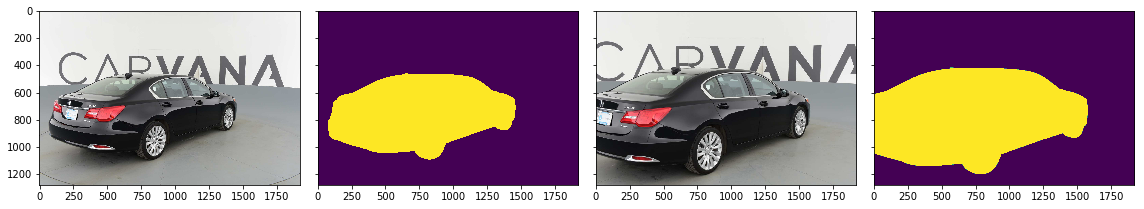

In [26]:
zoom_range=(0.2, 1)
img_zoom, mask_zoom = random_zoom(img, mask, u=1)
plot_img_and_mask_transformed(img, mask, img_zoom, mask_zoom)

## SHEAR
- intensity: Transformation intensity in degrees.
- Shear Intensity (Shear angle in counter-clockwise direction in degrees)

In [27]:
def random_shear(img, mask, intensity, u=0.5):
    if np.random.random() < u:
        shear = np.random.uniform(-intensity, intensity)
        img = image.apply_affine_transform(img, shear=shear, channel_axis=0, fill_mode="nearest", cval=0, order=1)
        mask = image.apply_affine_transform(mask, shear=shear, channel_axis=0, fill_mode="nearest", cval=0, order=1)
    return img, mask

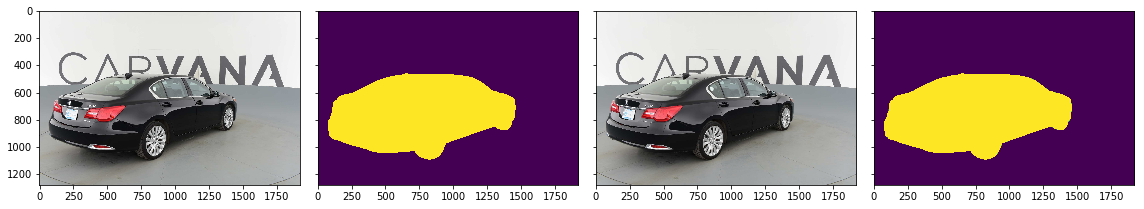

In [28]:
intensity = 0.2
img_shear, mask_shear = random_shear(img, mask, intensity, u=1)
plot_img_and_mask_transformed(img, mask, img_shear, mask_shear)

# Color Transformations
Now we will look at some transforms which doesn't require the same transformations to be applied on mask (since it is binary). We have the following transformations 

-  Random channel shift 
- Converting the color image to grayscale 
- Contrast Adjustments 
- Brightness Adjustments 
- Saturation Adjustments 

# Random Channel Shift
- Channel shifting is the process of taking the red, green or blue values of pixels in an image and applying those values to pixels in different positions on the image.

In [29]:
def random_channel_shift(x, limit, channel_axis=2):
    x = np.rollaxis(x, channel_axis, 0)
    min_x, max_x = np.min(x), np.max(x)
    channel_images = [np.clip(x_ch + np.random.uniform(-limit, limit), min_x, max_x) for x_ch in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_axis + 1)
    return x

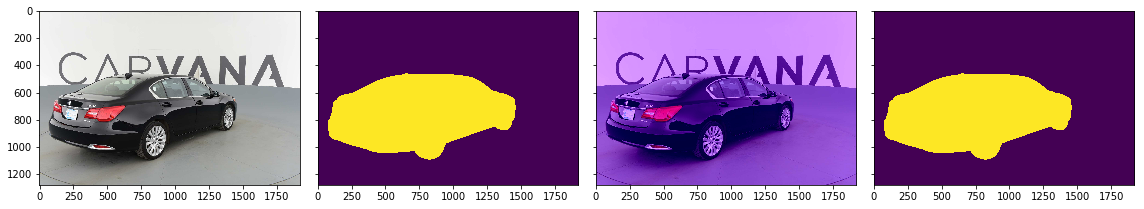

In [30]:
img_chsh = random_channel_shift(img, limit=0.5)
plot_img_and_mask_transformed(img, mask, img_chsh, mask)

# Grayscale 
- converting RGB images into Grayscale 

In [31]:
def random_gray(img, u=0.5):
    if np.random.random() < u:
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = np.sum(img * coef, axis=2)
        img = np.dstack((gray, gray, gray))
    return img

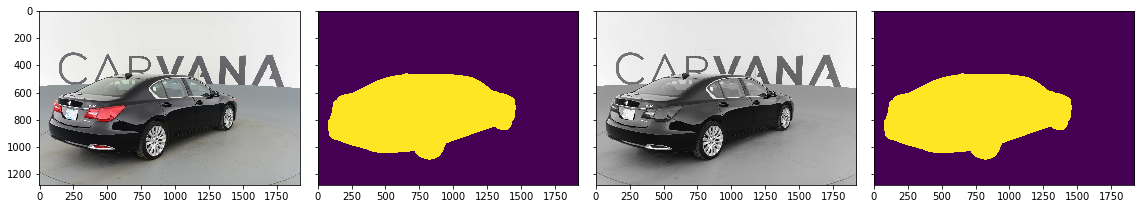

In [32]:
img_gray = random_gray(img, u=1)
plot_img_and_mask_transformed(img, mask, img_gray, mask)

# Brightness and Contrast 
- Brightness refers to the overall lightness or darkness of the image. Increasing the brightness every pixel in the frame gets lighter.
- Contrast is the difference in brightness between objects in the image. Increasing the contrast makes light areas lighter and dark area in the frame becomes much darker.

In [33]:
def random_contrast(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])  # rgb to gray (YCbCr)
        gray = img * coef
        gray = (3.0 * (1.0 - alpha) / gray.size) * np.sum(gray)
        img = alpha * img + gray
        img = np.clip(img, 0., 1.)
    return img

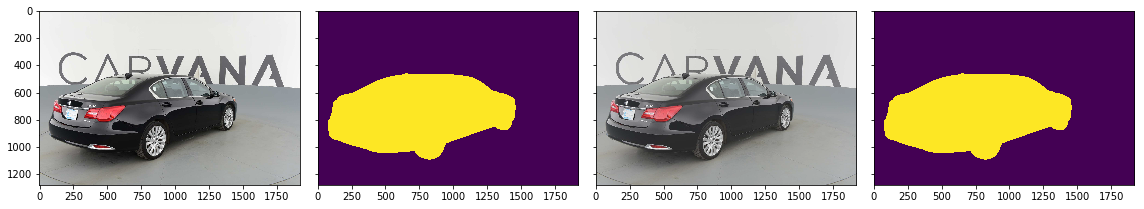

In [34]:
img_contrast = random_contrast(img, limit=(-1, 1),  u=1)
plot_img_and_mask_transformed(img, mask, img_contrast, mask)

In [35]:
def random_brightness(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        img = alpha * img
        img = np.clip(img, 0., 1.)
    return img

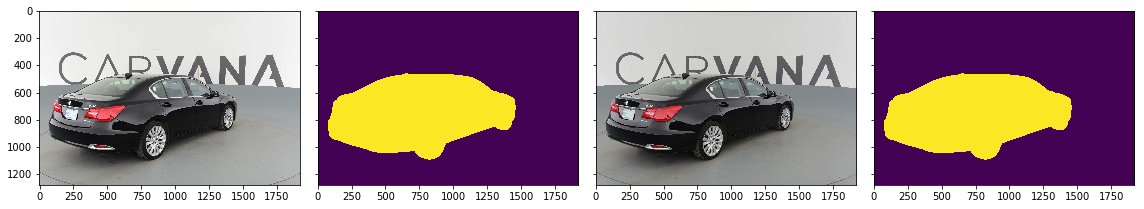

In [36]:
img_brightness = random_brightness(img, limit=(-0.3, 0.3),  u=1)
plot_img_and_mask_transformed(img, mask, img_brightness, mask)

# Saturation
Saturation is basically the intensity of a color, saturation determines the strength of a particular color. low saturation has the true color while saturation adds white color to the pure one. so highly saturated image will be too bright i.e. white

In [37]:
def random_saturation(img, limit=(-0.3, 0.3), u=0.5):
    if np.random.random() < u:
        alpha = 1.0 + np.random.uniform(limit[0], limit[1])
        coef = np.array([[[0.114, 0.587, 0.299]]])
        gray = img * coef
        gray = np.sum(gray, axis=2, keepdims=True)
        img = alpha * img + (1. - alpha) * gray
        img = np.clip(img, 0., 1.)
    return img

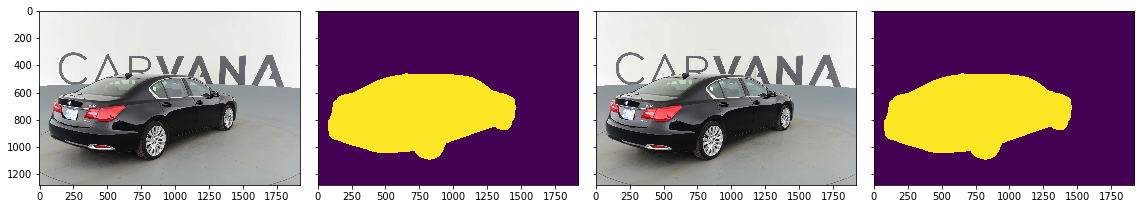

In [38]:
img_sat = random_saturation(img, limit=(-0.9, 0.9),  u=1)
plot_img_and_mask_transformed(img, mask, img_sat, mask)

# All together

Not all the transformations help the learning process. The limits here were chosen to have visible effects.

I am using less transformations and lower limits in my pipeline.


In [39]:
def random_augmentation(img, mask):
    img = random_channel_shift(img, limit=0.05)
    img = random_brightness(img, limit=(-0.5, 0.5), u=0.5)
    img = random_contrast(img, limit=(-0.5, 0.5), u=0.5)
    img = random_saturation(img, limit=(-0.5, 0.5), u=0.5)
    img = random_gray(img, u=0.2)
    img, mask = random_rotate(img, mask, rotate_limit=(-20, 20), u=0.5)
    img, mask = random_shear(img, mask, intensity=0.3, u=0.2)
    img, mask = random_flip(img, mask, u=0.3)
    img, mask = random_shift(img, mask, w_limit=(-0.1, 0.1), h_limit=(-0.1, 0.1), u=0.3)
    img, mask = random_zoom(img, mask, zoom_range=(0.8, 1), u=0.3)
    return img, mask

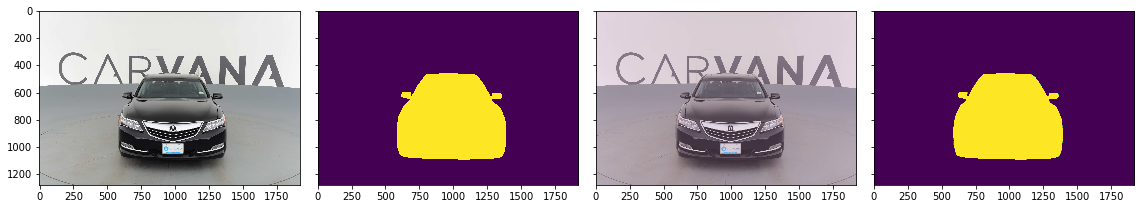

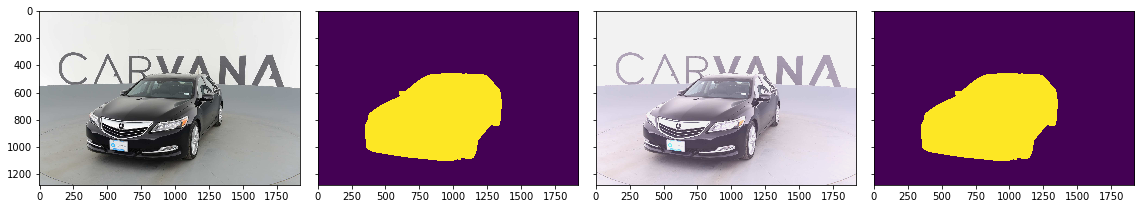

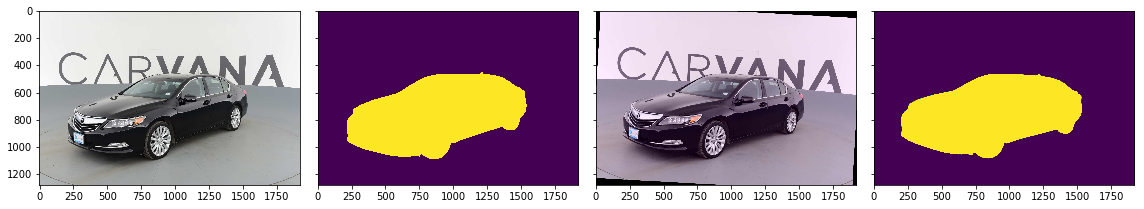

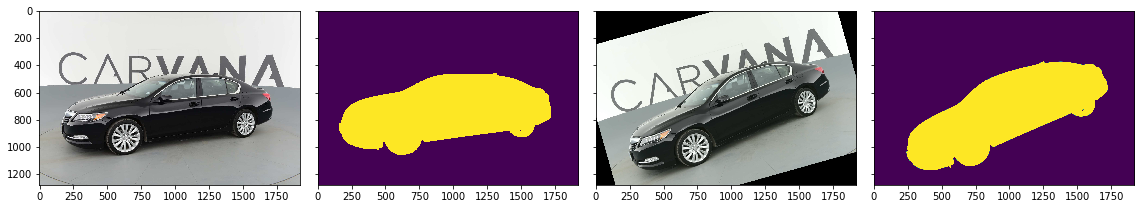

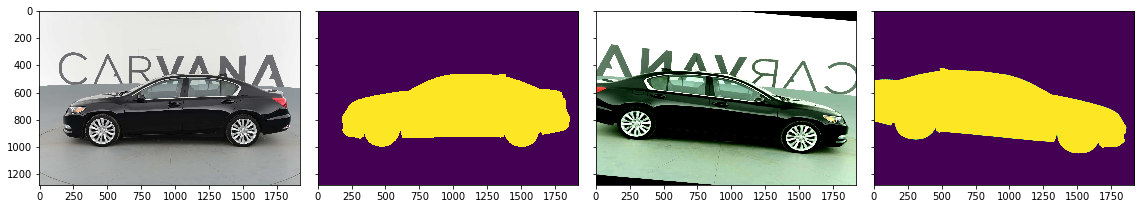

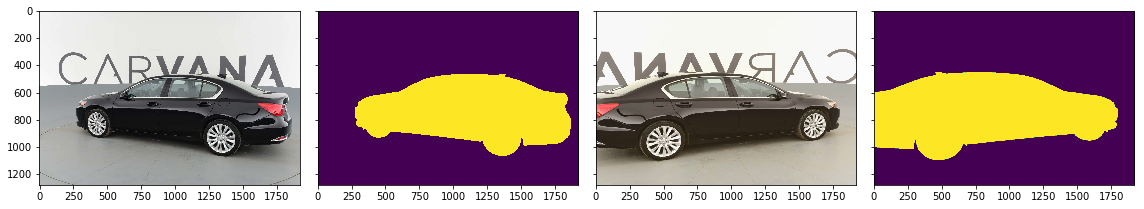

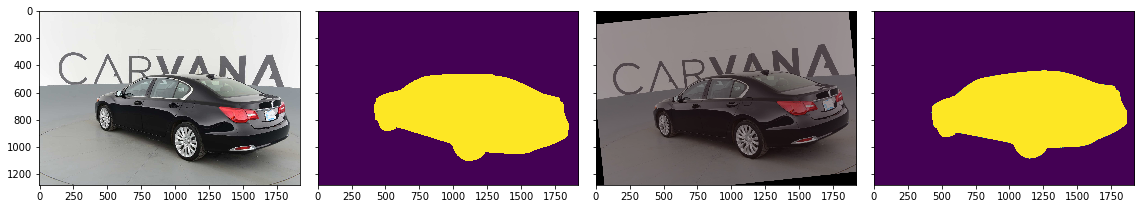

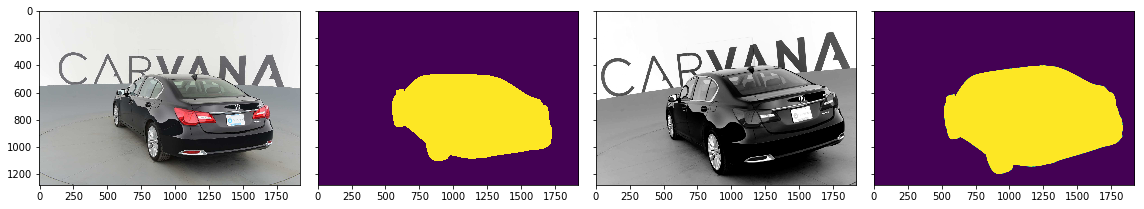

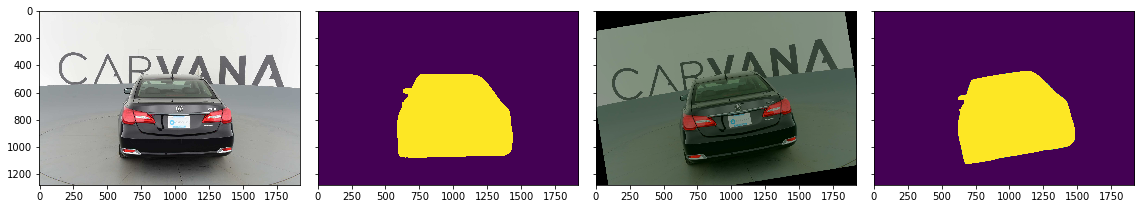

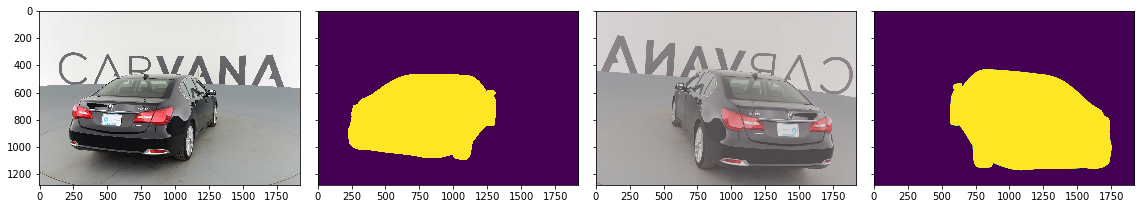

In [40]:
for img_id in train["img_id"].values[:10]:
    img, mask = get_image_and_mask(img_id)
    img_aug, mask_aug = random_augmentation(img, mask)
    plot_img_and_mask_transformed(img, mask, img_aug, mask_aug)

## Data Generator 
In this section since we understood how data augmentation works and whats inside the hood. Now our task is to build a data genertor which will feed data to our network continously.  The data generator should randomly pick N Ids (batch size), pick images and corresponding masks, Resize them to the required size, pass it through our augmentation module and output the final list. The two most important tasks with us are 
- build a data_generator for data
- divide the data into train and validation
- plot one batch of images to make sure that whatever is going into the network is correct

## keras.utils.Sequence
keras package has keras.utils.Sequence module which will allow you to write your own custom data generators. So lets have a close look at what keras.utils.Sequence contains.
- It is a class function which have getitem func, this outputs image and its respective mask for a given index (ID of the image). index values ranges from 0 to length of the dataset.
- len function, where we need to define how many batch of images are there in the dataset, So the datagenerator will know how many batch of images to run through for one epoch.
- on_epoch_end. This is an optinal method, which can be used to tell what to do after an epoch completes. We can use it to shuffle the data at the end of an epoch.
- iter func, this is again an optional method and can be ignored.

Lets define the class function. we have the following things
- root: str root location of the images 
- ids: list. List of all the image ids
- batch_size: 32 number of images to read in one batch
- resize_size: tuple, To resize the image to give size 
- transforms: True/Flase: weather to perform the transformation or not. If yes, we need to call the transformation function we called before.
- shuffle : True/False, weather to shuffle images after each and every epoch or not 

In [41]:
import keras
import numpy as np 
from keras.preprocessing import image
from os.path import join


class DataGenerator(keras.utils.Sequence):
    def __init__(self, list_ids, root="../input", batch_size=2, resize=(512, 512), transforms=False, shuffle=False):
        self.list_ids = list_ids
        self.root = root
        self.batch_size = batch_size
        self.resize = resize 
        self.transforms = transforms 
        self.shuffle = shuffle 
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.list_ids) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index* self.batch_size: (index+1)* self.batch_size]
        list_of_ids = [self.list_ids[i] for i in indexes]
        X, y = self.__data_generation(list_of_ids)
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.list_ids))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)
    
    def __data_generation(self, list_ids_temp):
        imgs = []
        masks = []
        for i in list_ids_temp:
            img, mask = self.get_image_and_mask(i, self.root, self.resize)
            if self.transforms:
                img, mask = random_augmentation(img, mask)
            imgs.append(np.expand_dims(img, 0))
            masks.append(np.expand_dims(mask, 0))
        return np.concatenate(imgs), np.concatenate(masks)
        
    
    def get_image_and_mask(self, img_id, data_dir = '../input', input_size=(512, 512)):
        img = image.load_img(join(data_dir, 'train', '%s.jpg' % img_id), target_size=input_size)
        img = image.img_to_array(img)
        mask = image.load_img(join(data_dir, 'train_masks', '%s_mask.gif' % img_id), color_mode="grayscale", target_size=input_size)
        mask = image.img_to_array(mask)
        img, mask = img / 255., mask / 255.
        return img, mask

- The data generator function is completed. Lets see how this works

In [42]:
train.head()

,img,rle_mask,id,img_id
0,00087a6bd4dc_01.jpg,879386 40 881253 141 883140 205 885009 17 8850...,00087a6bd4dc,00087a6bd4dc_01
1,00087a6bd4dc_02.jpg,873779 4 875695 7 877612 9 879528 12 881267 15...,00087a6bd4dc,00087a6bd4dc_02
2,00087a6bd4dc_03.jpg,864300 9 866217 13 868134 15 870051 16 871969 ...,00087a6bd4dc,00087a6bd4dc_03
3,00087a6bd4dc_04.jpg,879735 20 881650 26 883315 92 883564 30 885208...,00087a6bd4dc,00087a6bd4dc_04
4,00087a6bd4dc_05.jpg,883365 74 883638 28 885262 119 885550 34 88716...,00087a6bd4dc,00087a6bd4dc_05


In [43]:
ids = train["img_id"]
len(ids)

5088

In [44]:
## Defining the datagenerator. 
dataflow = DataGenerator(ids, batch_size = 16, shuffle=True)
dataflow

In [45]:
len(dataflow) ## Since we are using a batch size of 16 images this should output (5088/16) images

318

In [46]:
X, y = dataflow[1]
print(X.shape, y.shape)

(16, 512, 512, 3) (16, 512, 512, 1)


## Lets visualize these images and see how if everything is going well or not.

In [47]:
from skimage.util import montage # to visualize all the images at once.

Text(0.5,1,'$\\Delta$T Mask')

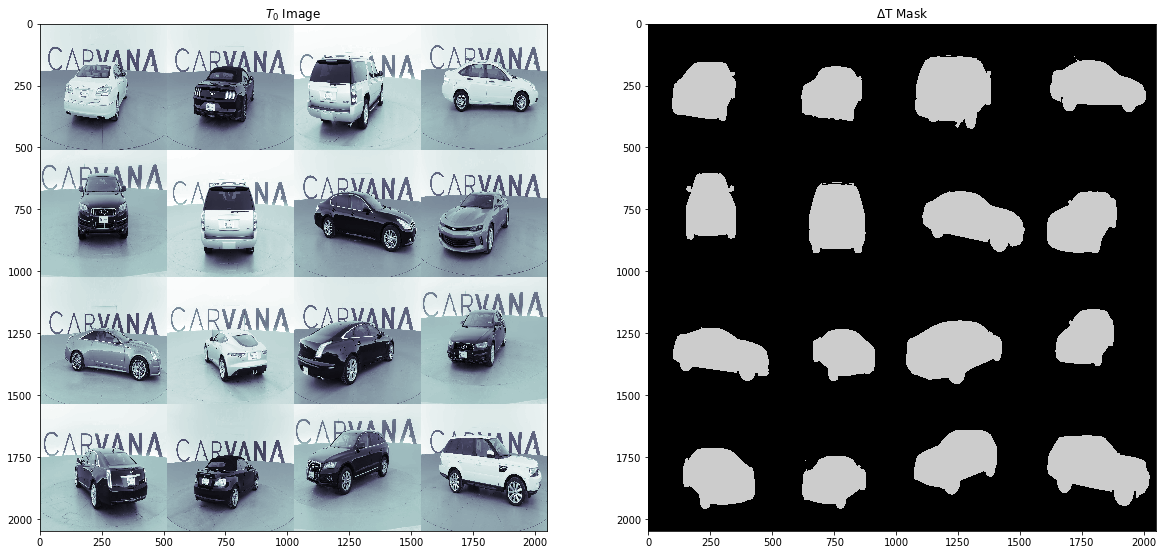

In [48]:
fig, (ax1, ax3) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(montage(X[:, :, :, 0]), cmap = 'bone')
ax1.set_title('$T_0$ Image')
ax3.imshow(montage(y[:, :, :, 0]), cmap = 'nipy_spectral')
ax3.set_title('$\Delta$T Mask')

This looks perfect and proves that our data loader is working fine. points to be noted here.
- Since transforms is true, if you call the **dataflow** func once again with the same index. We will get the same images in different angles (random_transformations)

## Part-2 
We have understood various data agumentation/translation techniques and how to build dataloaders in keras till now.  From now on there will be less code as most of the code is already written in keras and all we need to do is call necessary functions. There will be more concepts introduced. Pay attention to the theory.

For the part-2 we will be using the segmentation-models package available via pip or github (https://github.com/qubvel/segmentation_models/blob/master)
```bash
pip install segmentation-models
```

Segmentation models is python library with Neural Networks for Image Segmentation based on Keras (Tensorflow) framework.

The main features of this library are:
- High level API (just two lines to create NN).
- 4 models architectures for binary and multi class segmentation (including legendary Unet).
- 25 available backbones for each architecture.
- All backbones have pre-trained weights for faster and better convergence.

I will take a different approach in this task. Lets quickly train a neural network here by calling neccessary function and later go into the theory. we can
- call the basic Unet module with resnet34 backend
- call the bce_jaccard_loss function for loss calculation
- iou_score as the metric 
- train the model for few epochs to check the progress

Once this is done, we will go into the theory and discuss each layer. lets get started

In [49]:
!pip install segmentation-models

    100% |████████████████████████████████| 51kB 2.5MB/s ta 0:00:011
    100% |████████████████████████████████| 81kB 7.5MB/s ta 0:00:011


In [50]:
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score
from segmentation_models import Unet

/opt/conda/lib/python3.6/site-packages/classification_models/resnext/__init__.py:4: UserWarning: Current ResNext models are deprecated, use keras.applications ResNeXt models
  warnings.warn('Current ResNext models are deprecated, '


In [51]:
# define model
BACKBONE= "resnet18"
model = Unet(BACKBONE, encoder_weights='imagenet', input_shape=(512, 512, 3))
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])

44924928/44920640 [==============================] - 1s 0us/step


In [52]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn0 (Batch

## split the data into train and validation 
- while splitting we need to be careful, we have to make sure that the same car is not present in both train and validation. since each car contains 16 images we need to make that either all of them are present in train or validation

In [53]:

from sklearn.model_selection import train_test_split
ids = np.unique(train["id"].values)
x_train, x_val = train_test_split(ids, test_size=0.1, random_state= 42) ## this is wrong. we need to split it based on 
x_train = train[train["id"].isin(x_train)]["img_id"].values
x_val = train[train["id"].isin(x_val)]["img_id"].values
print(x_train.shape, x_val.shape)

(4576,) (512,)


In [54]:
## Defining the datagenerator. 
traingen = DataGenerator(list(x_train), batch_size=2, shuffle=True)
valgen = DataGenerator(list(x_val), batch_size=2, shuffle=True)

In [55]:
model.fit_generator(generator=traingen,
                    validation_data=valgen,
                    use_multiprocessing=True,
                    workers=6)

Epoch 1/1
2288/2288 [==============================] - 305s 133ms/step - loss: 0.0641 - iou_score: 0.9600 - val_loss: 0.6341 - val_iou_score: 0.7536


This is so easy to use. In the first epoch itself we reached an iou_score of 0.981. Though we have trained for only one epoch, we can train the network for multiple epochs till we get good valdation iou_score.  Now lets discuss about each and every parameter. 

First comes the architecutures. The segmentation module contains 4 architecutures.
- Unet
- FPN
- Linknet
- PSPNet

It is available with the following backends.
**Backbones**

|Type | Names |
|-------| -----------|
|VGG |         ``'vgg16' 'vgg19'``
|ResNet|       ``'resnet18' 'resnet34' 'resnet50' 'resnet101' 'resnet152'``
|SE-ResNet|    ``'seresnet18' 'seresnet34' 'seresnet50' 'seresnet101' 'seresnet152'``
|ResNeXt | ``'resnext50' 'resnet101'``
|SE-ResNeXt|   ``'seresnext50' 'seresnet101'``
|SENet154 |    ``'senet154'``
|DenseNet |    ``'densenet121' 'densenet169' 'densenet201'`` 
|Inception |   ``'inceptionv3' 'inceptionresnetv2'``
|MobileNet |   ``'mobilenet' 'mobilenetv2'``

 -  All backbones have weights trained on 2012 ILSVRC ImageNet dataset (``encoder_weights='imagenet'``). 
 - Intotal there are 24 backends and 4 different architecuture types. Combaining all of these we have 96 architecuture models. Now lets look at each of these architecutures using **resnet18** as backend.


## UNet 
- UNet uses the full image for segmentation. It takes an input as image and output a mask of the same size as input image.
- It consists of a contracting (encoder, left side) path and an expansive (decoder, right side). 
- The contracting path follows the typical architecture of a convolutional network. Here in this example we have used ResNet as an example. Inspite of the depth, there are 4 resblocks. To know more about resnet architecture (https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624).
- In each resblock we double the number of feature channels and reduce the size of feature map size by half.
- for increasing the size of feature map in decoder, we can use upsampling or convTranspose. In the diagram below we have used upsampling. I have showed in another figure how convTranspose works. The default in Unet function uses upsampling, we can use **transpose** for decoder_block_type to use convTranspose. Note this is a hyperparameter which you can use and test.
- Below are the parameters of UNet available. 

| Arguments | Default | Description |
| ----------------|------------| -----------------|
| backbone_name| "vgg16"| The type of decoder we want to use. We can use any of the 24 architecutures I noted above|
| input_shape| (None, None, 3) | By default it takes only 3 channel input image of any size. If you are mentioning the size, we need to match it with DataGenerator output size|
| activation| "sgmoid" | If it is 1 class use sigmoid, if it has multiple classes use "softmax"|
| encoder_weights| "imagenet" | By default it uses imagenet weights, we can keep None if we don't want to use imagenet weights, it will be randomly initialization in that case.|
| encode_freeze | False |  If True, the encoder weights are freezed and the weights will not be trained.|
| decoder_block_type| "upsampling" | We can either use "upsampling" or "transpose" (conv2dTranspose is used)|
| decoder_filters| (256, 128, 54, 16) | This goes in line with the type of encoder used.|
| decoder_use_batchnorm| True | whether to use batchnorm or not in decoder block|

## Transposed Convolutions
Transposed Convolutions also called fractionally strided convolutions or deconvolutions - work by swapping the forward and backward passes of a convolution 

- https://github.com/keras-team/keras-preprocessing/blob/master/keras_preprocessing/image/affine_transformations.py

## LinkNet
- LinkNet is a full image segmentation Network designed for efficency and speed.
- compared to UNet discussed above which has 14.3 million parameters we have only 11.17 million parameters. 
- The author hypothesis is that while pooling a lot of local information is lost and adding input of each stage in encoder to the output each stage to decoder will recover some lost information. So every input of Encoder is added to the output of Decoder as shown in the figure . Note that they have added the values as link in ResNet like structure rather than concatenate it.
- Each Decoder block contains 1 x 1 conv layer followed by upsampling layer (conv2dTranspose or upsample) , 3x3 conv and a 1x1 conv layer. The initial conv layer reduces the number of feature map reduces the number of feature maps by 4 and the final conv layer increases it by 2 (Except for the last block), this overall increase the feature map size by 2 after every block. 
- The Author also validates the network by running various tests on cityscapes datasets and compares it with other architecutures. Due to its resnet like structure across skip-connections, other networks with even deeper encoders like VGG19 or ResNet101 underperformed compared to LinkNet with resnet18 backend. 
- Below are some important parameters used in LinkNet. 

| Arguments | Default | Description |
| ----------------|------------| -----------------|
| backbone_name| "vgg16"| The type of decoder we want to use. We can use any of the 24 architecutures I noted above|
| input_shape| (None, None, 3) | By default it takes only 3 channel input image of any size. If you are mentioning the size, we need to match it with DataGenerator output size|
| activation| "sigmoid" | If it is 1 class use sigmoid, if it has multiple classes use "softmax", use "linear" incase if you want to use your own function|
| encoder_weights| "imagenet" | By default it uses imagenet weights, we can keep None if we don't want to use imagenet weights, it will be randomly initialization in that case.|
| encode_freeze | False |  If True, the encoder weights are freezed and the weights will not be trained.|
| decoder_block_type| "upsampling" | We can either use "upsampling" or "transpose" (conv2dTranspose is used)|
| decoder_filters| (None, None, None, None, 16) | for block with skip connection a number of filters is equal to number of filters in corresponding encoder block|
| decoder_use_batchnorm| True | whether to use batchnorm or not in decoder block|

In [56]:
from segmentation_models import Linknet
BACKBONE= "resnet18"
model = Linknet(BACKBONE, encoder_weights='imagenet', input_shape=(512, 512, 3))

In [57]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 512, 512, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_19 (ZeroPadding2 (None, 518, 518, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 256, 256, 64) 9408        zero_padding2d_19[0][0]          
__________________________________________________________________________________________________
bn0 (Batch

In [58]:
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
model.fit_generator(generator=traingen,
                    validation_data=valgen,
                    use_multiprocessing=True,
                    workers=6)

Epoch 1/1
2288/2288 [==============================] - 308s 134ms/step - loss: 0.0653 - iou_score: 0.9586 - val_loss: 0.0328 - val_iou_score: 0.9794


## Pyramid Scene Parsing Network (PSPNet)
- This network came 1st in ImageNet scene parsing challenge 2016, PASCAL VOC 2012 benchmark, CityScapes benchmark.
- A single PSPNet yields the new record of mIoU accuracy of 85.4% on Pascal VOC 2012 and accuracy of 80.2% on Cityscapes 
- One of the problems with fully convolutional networks is that it doesn't have global context of the images.  For example in PSPNet paper they show that a boat on the river is being predicted as car, The author hypothesis that this is because the network doesn't look at the global perspective of the image. Inorder to solve this this paper launches **Pyramid Pooling Module (PPM)** (shown in the graph below). 
- We have resnet as an encoder which is defined by downsampling rate. In the below diagram we used a downsampling rate of 8, so whereever the feature map size 8 times smaller than the input size, we will stop there. In the diagram we used a (480, 480) input image which at stage-3 of ResNet block is (60, 60) with 128 filter maps. These are fed to PPM block.
- The PPM module fuses features under four different pyramid scales. we have 4 feature pooling layers which brings down the size from (60 x 60) to  (1, 1), (2, 2), (3, 3), (6, 6). Each pooling layer is followed by a 1 x 1 Conv block which expands the feature maps from 128 to 512. This followed by a resizing each of the feature map to (60 x 60) again using bilinear interpolation.
-  We concatenate the prior with the original feature map in the final part, where the filter maps increase to 2176.
- Concatenation is followed by 1 x 1 conv layer to reduce the filter maps to 512, further  1 x  1 conv reduces the filter maps to number of classes maintaining (60 x 60) feature map size. 
- The featue map is resized using bilinear interpolation to 480 x 480 and we apply sigmoid or softmax at the final stage. 

Now lets look at the various parameters and how it effected the accuracy 


| Arguments | Default | Description |
| ----------------|------------| -----------------|
| backbone_name| "vgg16"| The type of decoder we want to use. We can use any of the 24 architecutures I noted above|
| input_shape| (384, 384, 3) | By default it takes only 3 channel input image of any size. If you are mentioning the size, we need to match it with DataGenerator output size. There is a shape guard to this parameter which makes sure that h, w of the input shape is divisible by (downsample_factor * 6)|
| activation| "softmax" | If it is 1 class use sigmoid, if it has multiple classes use "softmax", use "linear" incase if you want to use your own function. Compared to other nets, where the nets have "sigmoid" as output this net has output as "softmax"|
| classses| 21 | The number of classes. |
| encoder_weights| "imagenet" | By default it uses imagenet weights, we can keep None if we don't want to use imagenet weights, it will be randomly initialization in that case.|
| encode_freeze | False |  If True, the encoder weights are freezed and the weights will not be trained.|
| downsample_factor| 8 | Where to stop the decoder|
| psp_conv_filters| 512 | How many filters to use in the PSP block conv layer|
| psp_pooling_type| "avg" | whether to use "avg" pooling or "max" pooling|
| psp_dropout| None | Whether to use dropout or not. This is not shown in our diagram but after concatenation we can add a dropout layer and drop some of the filters to avoid over fitting|
| final_interpolation| "bilinear"| Default is "bilinear" but we can use "duc" also which applies conv block and reshapes the outputs of it to image_size|

The authors of this paper have added several ablations studies in this paper. I will mention a few below so that it helps you in hyper parameter tuning 
- The authors emperically found that Avg pooling performed better than Max pooling 
- The authors emperically found that PSP module with 4 layers (1, 2, 3, 6) is better than 1 layer (1).
-  The performance improved by adding 1x1 conv block to reduce the dimension of the features. 
- with network depth increasing (resnet18, resnet50, resnet152, resnet269) the performance increased.
- Multi-scale testing and Data agumentation improves the perfomance of the network further. 

Go through the paper https://arxiv.org/pdf/1612.01105.pdf for better understanding 

In [59]:
from segmentation_models import PSPNet
BACKBONE= "resnet34"
model = PSPNet(BACKBONE, encoder_weights='imagenet', input_shape=(528, 528, 3), num_classes=1, activation="sigmoid")

85524480/85521592 [==============================] - 1s 0us/step


In [60]:
## Defining the datagenerator. 
traingen = DataGenerator(list(x_train), batch_size=4, shuffle=True, resize=(528, 528))
valgen = DataGenerator(list(x_val), batch_size=4, shuffle=True, resize=(528, 528))

In [61]:
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
model.fit_generator(generator=traingen,
                    validation_data=valgen,
                    use_multiprocessing=True,
                    workers=6)

Epoch 1/1
1144/1144 [==============================] - 268s 235ms/step - loss: 0.0817 - iou_score: 0.9466 - val_loss: 0.0636 - val_iou_score: 0.9571


## FPN
- **Feature Pyramid networks (FPN)** launched by Kaiming He and team has improved the object detection accuracy a lot. All the frameworks introduced till then like Faster RCNN, Mask-RCNN, RetinaNet were upgraded with FPN layers and saw increased performance. 
- Having a unified framework (Network) for object detection, instance segmentation and semantic segmentation would be of great help as this would make your network selection simple and spend your time in tuning other parameters instead of selecting/designing networks. 
- before the invention of FPN researchers while submitting results to the Imagenet and other challenges used to use multi-scale approach to improve their accuracies. For example, We resize an image into various sizes (in the form of image pyramid) and send each image to the network and later aggreagate the results. Their hypothesis is that small image will capture small objects and larger images will capture large objects and can be proved by the results obtained. One of the problems with this is that the train and test are evaluated differently and sending multiple images to the network is time consuming.
- The author came out with this network called FPN where instead of image pyramids, take features after each resblock and use them in the pyramid form. Thus feature pyramid network. 
- Each Pyramid has different feature map size and channels. The earlier layers have better localization features and later layers have rich semantic features, combining these will lead to a rich semantic with better localization features. This leads to having both global context and local context.
- Each resblock output is attached to a (1 x 1) conv block to bring the filter maps to 256.
- The network follows a top-down approach where the features of the top layer are resized to one layer before that and added to it in the form of skip connections followed by resnet architecuture. 
- Each top-down layer is then attached two 3 x 3 conv layers which brings down the filter maps to 128 keeping the size of feature maps the same.
- All the segmentation layers are resized to 128 x 128 using tensorflow Resize bilinear option and later concatenated increasing the filter maps to 512 (128 x four layers)
- A 3x3 conv layer followed by another 3x3 conv layer to reduce the number of filter maps to num_classes. This is followed by a resize layer which resizes the image to input size. The last activation layer is applied (sigmoid for one class and softmax if number of classes greater than 1) .
- More information go through this link http://presentations.cocodataset.org/COCO17-Stuff-FAIR.pdf

In [62]:
from segmentation_models import FPN
BACKBONE= "resnet34"
model = FPN(BACKBONE, encoder_weights='imagenet', input_shape=(512, 512, 3), num_classes=1, activation="sigmoid")

In [63]:
## Defining the datagenerator. 
traingen = DataGenerator(list(x_train), batch_size=4, shuffle=True, resize=(512, 512))
valgen = DataGenerator(list(x_val), batch_size=4, shuffle=True, resize=(512, 512))

In [ ]:
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score])
model.fit_generator(generator=traingen,
                    validation_data=valgen,
                    use_multiprocessing=True,
                    workers=6)

## Metrics 
Metrics are the way of knowing how well your model is performing. In the above examples we have used iou_score without much knowledge about it.  In segmentation there are various metrics used to calculate the network performace. Lets look at a few of the most important metrics below and the use cases when we need to use it.
1) f1_score or dice_score
2) f2_score
3) iou_score
4) pixel accuracy.

Before going in depth of metrics, lets dive into some of the terminology. The below diagram from wikipedia comes handy to answer a lot of questions.

**True Positives (TP)** - These are the correctly predicted positive values which means that the value of actual class is yes and the value of predicted class is also yes. 

**True Negatives (TN)** - These are the correctly predicted negative values which means that the value of actual class is no and value of predicted class is also no.

False positives and false negatives, these values occur when your actual class contradicts with the predicted class.

**False Positives (FP)** – When actual class is no and predicted class is yes. 

**False Negatives (FN)** – When actual class is yes but predicted class in no.

Once you understand these four parameters then we can calculate Accuracy, Precision, Recall and F1 score.

**Precision** - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. 

Precision = TP/TP+FP

**Recall (Sensitivity)** - Recall is the ratio of correctly predicted positive observations to the all observations in actual class.

Recall = TP/TP+FN

## Pixel Accuracy
Accuracy - Accuracy is the most intuitive performance measure and it is simply a ratio of correctly predicted observation to the total observations. One may think that, if we have high accuracy then our model is best. Yes, accuracy is a great measure but only when you have symmetric datasets where values of false positive and false negatives are almost same. Therefore, you have to look at other parameters to evaluate the performance of your model. 

Accuracy = TP+TN/TP+FP+FN+TN


## F1 score or Dice Score 
F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. 

F1 Score = 2*(Recall * Precision) / (Recall + Precision) which can also be written as 
F1 Score = 2TP/ (2TP + FP + FN)

## F2 Score 
Since F1 score is only the hormonic mean of precision and recall it weights precision and recall the same way. What if you want to keep more weight to precision then recall or the reverse, here comes the **fbeta_score**. 

fbeta_score = ((1 + beta ** 2) * tp ) \
/ ((1 + beta ** 2) * tp + beta ** 2 * fn + fp )

The F-beta score is the weighted harmonic mean of precision and recall, reaching its optimal value at 1 and its worst value at 0. The beta parameter determines the weight of precision in the combined score. beta < 1 lends more weight to precision, while beta > 1 favors recall (beta -> 0 considers only precision, beta -> inf only recall).

F2 score means keeping beta value at 2, which means favoring recall more.

## IOU score 
The Jaccard Index also known as Intersection over Union and the jaccard similarity coefficient is a statistic used to compare the similarity and diversity of sample sets. The jaccard coefficient measures similarity between finite sample sets, and is defined as the size of the intersection by the size of the union of the sample sets. We can understand this using a venn diagram below
- Is calculated across each class and then average over all the classes.
- from the figure A and B are two sets and let the intersection area be C. IOU score is equal to C/(A+B-C)
- The maximum value is 1 when A and B perfectly overlap on top of each other and minimum value is 0 when A and B doesnt overlap at all (A U B = 0).
- IOU in terms of TP, FP and FN can be written as TP/(TP+FP+FN)

## Loss Functions 
- For any deep learning models we need to have a loss function that needs to be optimized. In the above experiements we have used **bce_jaccard_loss** without much knowledge about it. In this section lets look at the intution behind each loss function and how they are calculated.

The major loss functions include
- Jaccard loss also known as jaccard index 
- dice_loss 


## Jaccard loss or BCE_Jaccard loss or cce_jaccard loss
- Jaccard loss is 1-iou_score but this loss is generally not used alone as it suf


## Pending things to do 
- Revisit loss and metric description
- Integrate diagrams
- change the dataset if required 
- ConvTranspose vs Dilated Conv
- plot the outputs of each model
- Hyperparameter tuning on UNet example 
- Resources section
- Betatesting on a user